# __Applying PCM to ARGO data in Mediterranean Sea__

The aim of this notebook is to be an example of applying the PCM method to in-situ T-S profiles. The dataset is a selection of Argo profiles localted in Mediterranean sea. Notebook developped and run in __local__

Libraries needed:

In [1]:
import xarray as xr
# xr.set_options(display_style='text')
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

import argopy
# not at home
#argopy.set_options(cachedir='/home1/homedir5/perso/agarciaj/.cache/argopy',src='localftp',local_ftp='/home/ref-argo/gdac')
from argopy import DataFetcher as ArgoDataFetcher
argo_loader = ArgoDataFetcher()
#argo_loader = ArgoDataFetcher(cache=True)
# trying parallel-requests
#argo_loader = ArgoDataFetcher(src='erddap', parallel=True, chunks={'wmo': 2})

import pyxpcm
from pyxpcm.models import pcm

from Plotter import Plotter #new class for plots in pyxpcm

## Getting data
***

We acces to data using argopy python library

<font color=red>TODO</font>: region option makes a square around Mediterranean sea, including some profiles in Black Sea and Atlantic Ocean --> Try to access data using WMO and profile number

In [2]:
# only one year
ds = argo_loader.region([-6, 35, 30, 46, 0, 1000, '2012', '2013']).to_xarray()
#ds

<font color=red>TODO</font>: try to use more than one year (memory limits ?)

In [3]:
# trying yo use more than one year
#ds1 = argo_loader.region([30, 46, -6, 35, 0, 1000, '2011', '2012']).to_xarray()
#ds2 = argo_loader.region([30, 46, -6, 35, 0, 1000, '2012', '2013']).to_xarray()
#ds = xr.concat([ds1,ds2],dim='N_POINTS')
#ds

In [4]:
dsp = ds.argo.point2profile()
#dsp

In [5]:
# interpolation to standard levels
z = np.arange(0.,1000,10.)
#z

with `z = np.arange(0.,200,1.)` interpolation is not working

In [6]:
dsi = dsp.argo.interp_std_levels(z)
#dsi

Pressure should be negative to fit the model

In [7]:
dsi['PRES_INTERPOLATED'] = -dsi.PRES_INTERPOLATED
#dsi

## Applying PCM
***

We creates a model with K classes and temperature or salinity or both as features

### Create PCM

In [8]:
z = np.arange(0.,-1000,-10.)
# only temperature to try temporal representation
# pcm_features = {'temperature': z, 'salinity' : z}
pcm_features = {'temperature': z}
m = pcm(K=6, features=pcm_features)
m

<pcm 'gmm' (K: 6, F: 1)>
Number of class: 6
Number of feature: 1
Feature names: odict_keys(['temperature'])
Fitted: False
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>

### Fit model

In [9]:
# only temperature to try temporal representation
# features_in_ds = {'temperature': 'TEMP', 'salinity': 'PSAL'}
features_in_ds = {'temperature': 'TEMP'}
features_zdim='PRES_INTERPOLATED'
m.fit(dsi, features=features_in_ds, dim=features_zdim)
m

<pcm 'gmm' (K: 6, F: 1)>
Number of class: 6
Number of feature: 1
Feature names: odict_keys(['temperature'])
Fitted: True
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: -3.795625

<font color=red>__TODO__</font> : save all trained PCM in a folder

### Classify data

In [10]:
m.predict(dsi, features=features_in_ds, dim=features_zdim, inplace=True);
#dsi

In [11]:
m.predict_proba(dsi, features=features_in_ds, dim=features_zdim, inplace=True);
#dsi

In [12]:
dsi = dsi.pyxpcm.quantile(m, q=[0.05, 0.5, 0.95], of='TEMP', outname='TEMP' + '_Q', keep_attrs=True, inplace=True);
# dsi = dsi.pyxpcm.quantile(m, q=[0.05, 0.5, 0.95], of='PSAL', outname='PSAL' + '_Q', keep_attrs=True, inplace=True)
#dsi

In [13]:
#dsi

## Visualisation
***

Initialize Plotter

In [14]:
P = Plotter(dsi, m, data_type = 'profiles')

#### 1. Vertical structure of classes

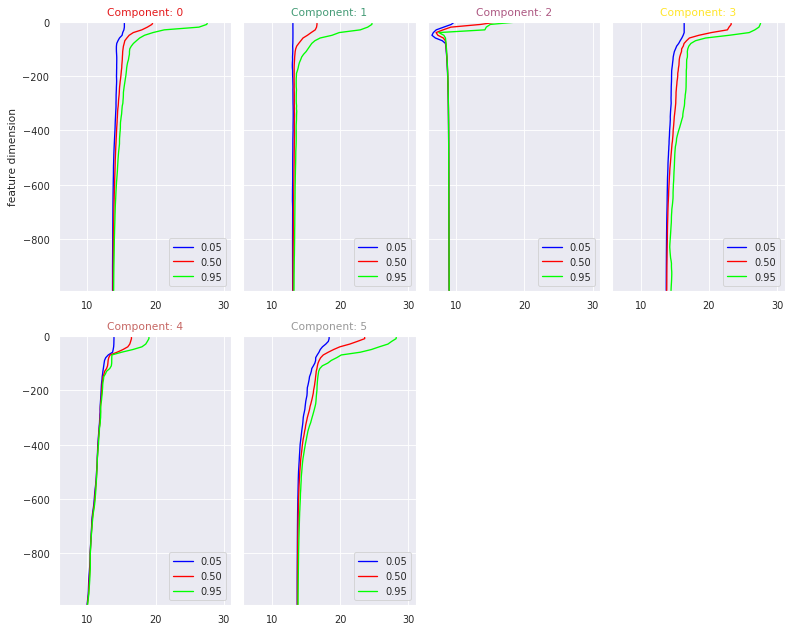

In [15]:
P.vertical_structure(q_variable = 'TEMP_Q')
#plt.savefig('figures/vertical_struc_EX.png')

#### 2. Spatial distribution of classes

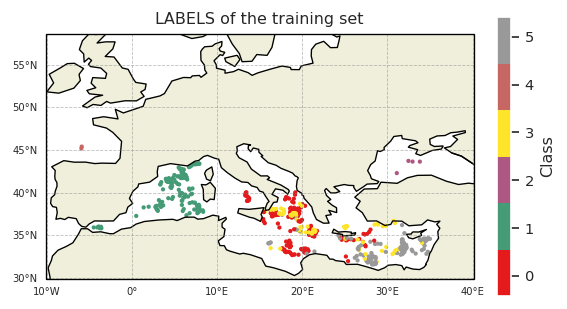

In [16]:
P.spatial_distribution(proj=ccrs.PlateCarree(), extent=np.array([-10,40,30,56]) + np.array([-0.1,+0.1,-0.1,+0.1]), 
                       co = {'latitude':'LATITUDE', 'longitude':'LONGITUDE'})
#plt.savefig('figures/spatial_distr_EX.png')

#### 3. Posteriors

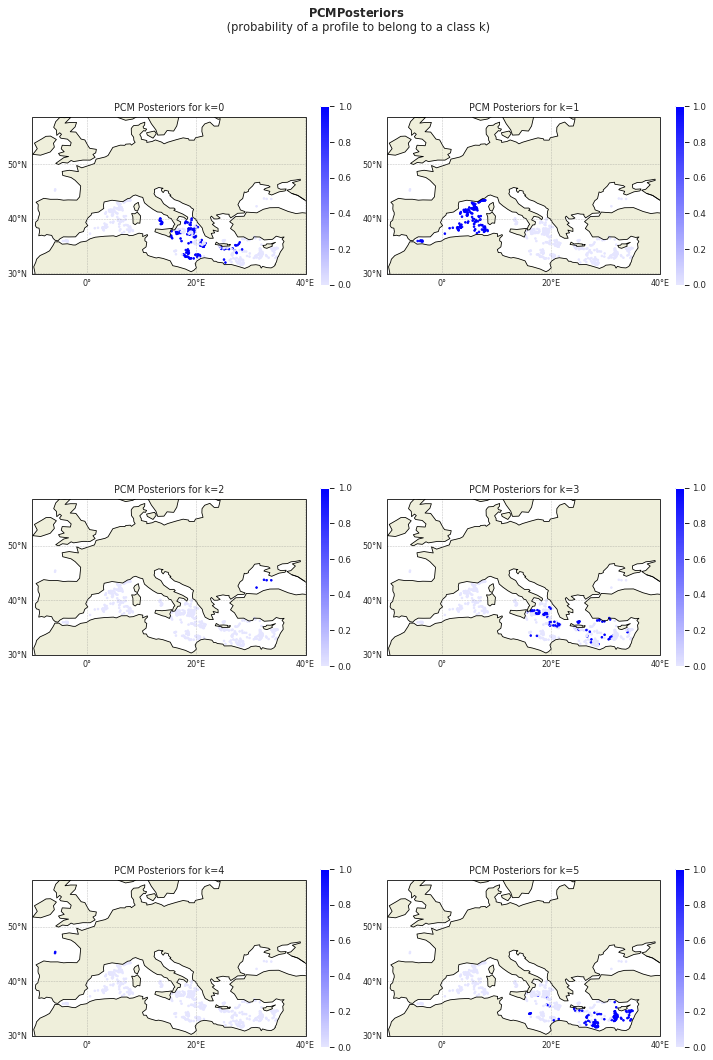

In [17]:
P.plot_posteriors(proj=ccrs.PlateCarree(), extent=np.array([-10,40,30,56]) + np.array([-0.1,+0.1,-0.1,+0.1]), 
                       co = {'latitude':'LATITUDE', 'longitude':'LONGITUDE'})
#plt.savefig('figures/posteriors_EX.png')

#### 4. Temporal representation

Simple histogram

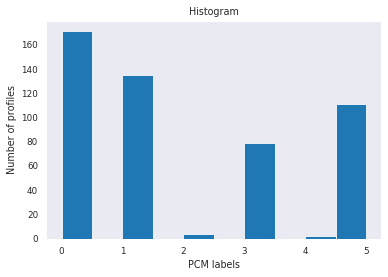

In [18]:
fig, axes = plt.subplots()
dsi['PCM_LABELS'].plot.hist()
# y axis is number of profiles
axes.set_ylabel('Number of profiles')
#plt.savefig('figures/simple_hist_EX.png')
plt.show()

Bar plot by __month__

<xarray.DataArray 'PCM_LABELS' (month: 12)>
array([12,  5,  8, 18, 29, 36, 27, 13,  7,  3,  0, 13])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
<xarray.DataArray 'PCM_LABELS' (k: 2, month: 12)>
array([[12,  5,  8, 18, 29, 36, 27, 13,  7,  3,  0, 13],
       [ 7, 10,  9,  6,  8,  8, 12,  5, 16, 10, 23, 21]])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: k
<xarray.DataArray 'PCM_LABELS' (k: 3, month: 12)>
array([[12,  5,  8, 18, 29, 36, 27, 13,  7,  3,  0, 13],
       [ 7, 10,  9,  6,  8,  8, 12,  5, 16, 10, 23, 21],
       [ 0,  0,  0,  1,  1,  1,  0,  0,  0,  0,  1,  0]])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: k
<xarray.DataArray 'PCM_LABELS' (k: 4, month: 12)>
array([[12,  5,  8, 18, 29, 36, 27, 13,  7,  3,  0, 13],
       [ 7, 10,  9,  6,  8,  8, 12,  5, 16, 10, 23, 21],
       [ 0,  0,  0,  1,  1,  1,  0,  0,  0,  0,  1,  0],
       [ 4,  3,  4,  5,

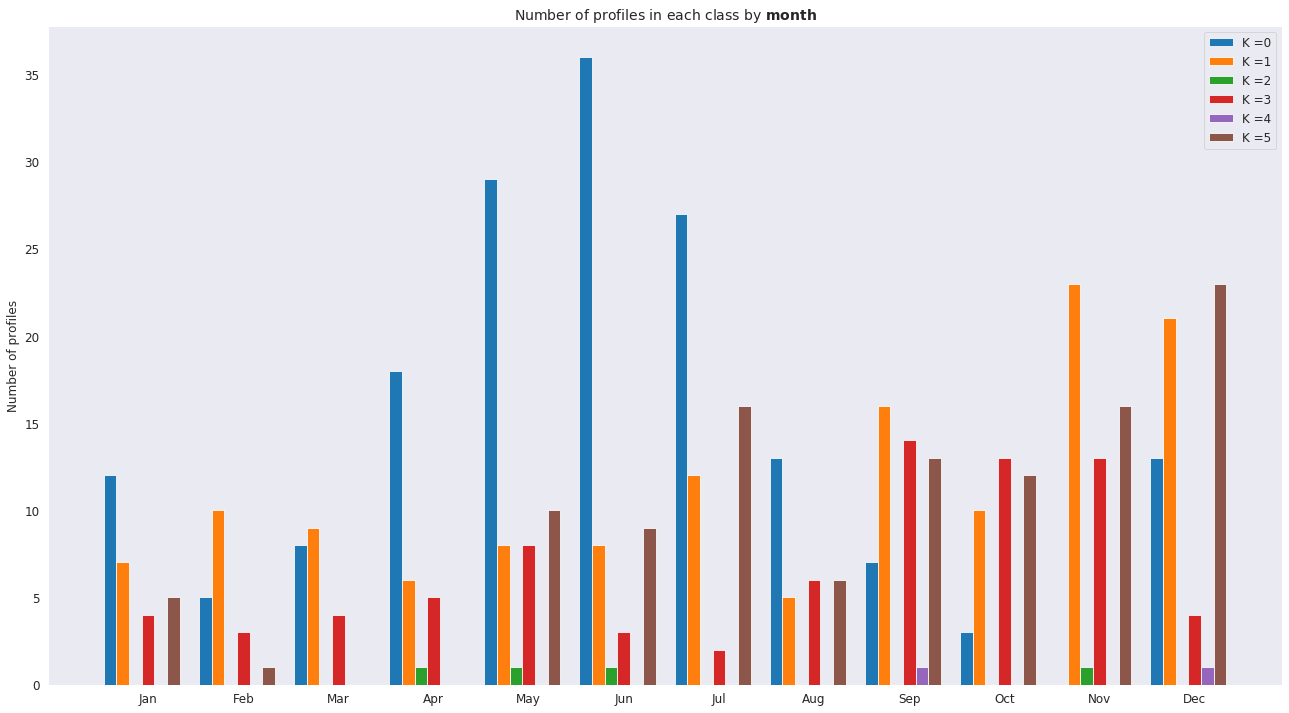

In [19]:
P.temporal_distribution(time_variable = 'TIME', time_bins = 'month', pond = 'abs')
#plt.savefig('figures/temporal_distr_months_EX.png')

Bar plot by __month__ (__relative__ number of profiles per month)

<xarray.DataArray 'PCM_LABELS' (month: 12)>
array([12,  5,  8, 18, 29, 36, 27, 13,  7,  3,  0, 13])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
<xarray.DataArray 'PCM_LABELS' (k: 2, month: 12)>
array([[12,  5,  8, 18, 29, 36, 27, 13,  7,  3,  0, 13],
       [ 7, 10,  9,  6,  8,  8, 12,  5, 16, 10, 23, 21]])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: k
<xarray.DataArray 'PCM_LABELS' (k: 3, month: 12)>
array([[12,  5,  8, 18, 29, 36, 27, 13,  7,  3,  0, 13],
       [ 7, 10,  9,  6,  8,  8, 12,  5, 16, 10, 23, 21],
       [ 0,  0,  0,  1,  1,  1,  0,  0,  0,  0,  1,  0]])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: k
<xarray.DataArray 'PCM_LABELS' (k: 4, month: 12)>
array([[12,  5,  8, 18, 29, 36, 27, 13,  7,  3,  0, 13],
       [ 7, 10,  9,  6,  8,  8, 12,  5, 16, 10, 23, 21],
       [ 0,  0,  0,  1,  1,  1,  0,  0,  0,  0,  1,  0],
       [ 4,  3,  4,  5,

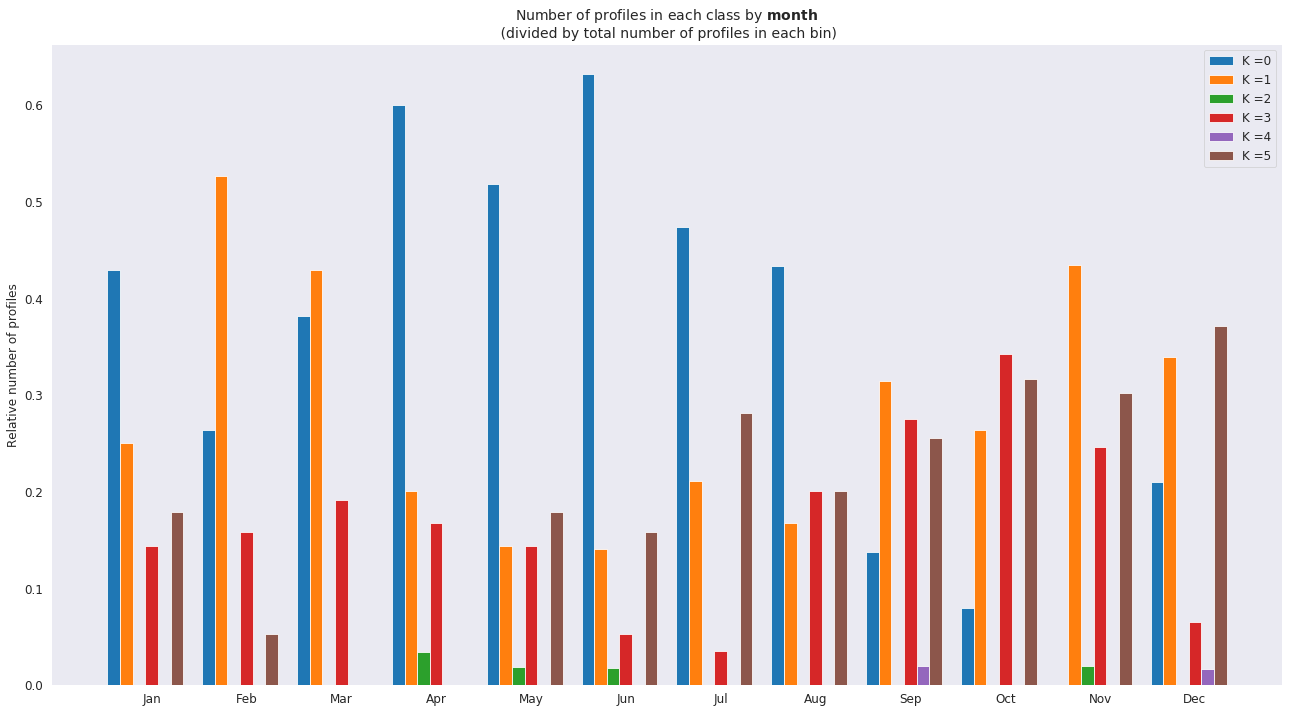

In [20]:
P.temporal_distribution(time_variable = 'TIME', time_bins = 'month', pond = 'rel')

Bar plot by __season__

<xarray.DataArray 'PCM_LABELS' (season: 4)>
array([30, 76, 55, 10])
Coordinates:
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
<xarray.DataArray 'PCM_LABELS' (k: 2, season: 4)>
array([[30, 76, 55, 10],
       [38, 25, 23, 49]])
Coordinates:
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Dimensions without coordinates: k
<xarray.DataArray 'PCM_LABELS' (k: 3, season: 4)>
array([[30, 76, 55, 10],
       [38, 25, 23, 49],
       [ 0,  1,  2,  1]])
Coordinates:
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Dimensions without coordinates: k
<xarray.DataArray 'PCM_LABELS' (k: 4, season: 4)>
array([[30, 76, 55, 10],
       [38, 25, 23, 49],
       [ 0,  1,  2,  1],
       [11, 11, 17, 40]])
Coordinates:
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Dimensions without coordinates: k
<xarray.DataArray 'PCM_LABELS' (k: 5, season: 4)>
array([[30, 76, 55, 10],
       [38, 25, 23, 49],
       [ 0,  1,  2,  1],
       [11, 11, 17, 40],
       [ 1,  0,  0,  1]])
Coordinates:

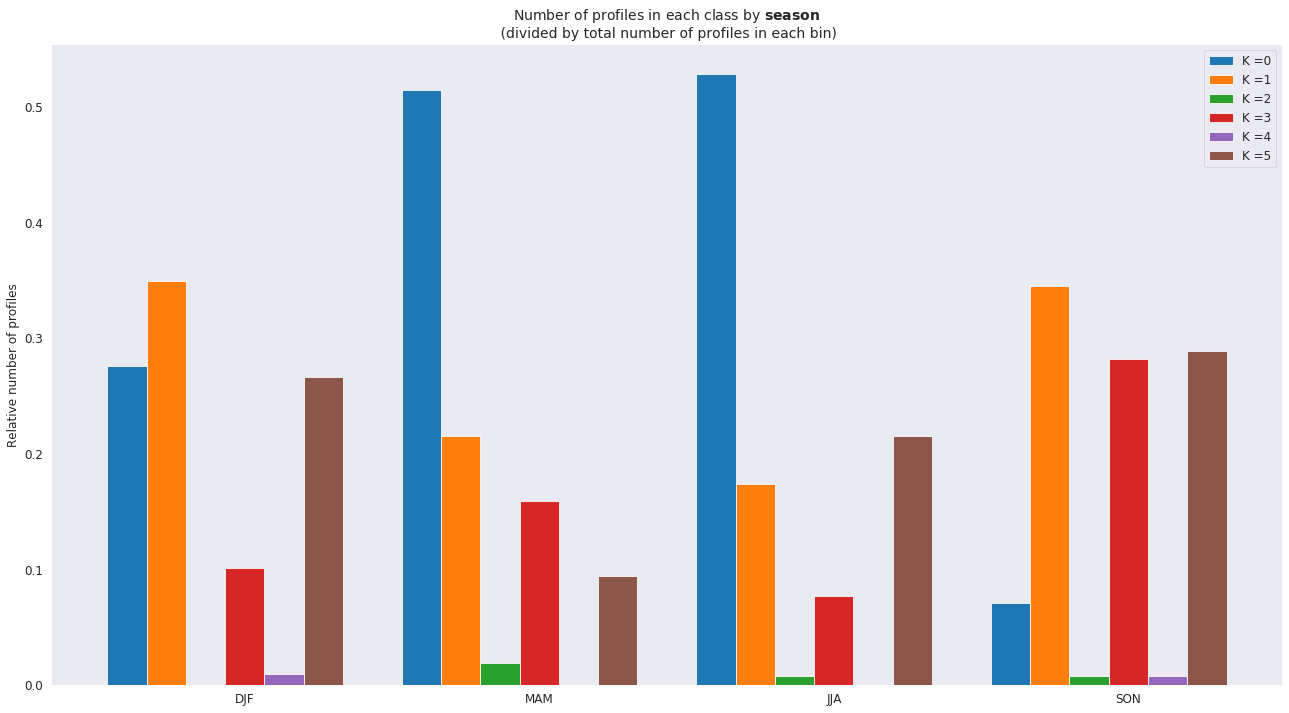

In [22]:
P.temporal_distribution(time_variable = 'TIME', time_bins = 'season', pond = 'rel')
plt.savefig('figures/temporal_distr_season_EX.png')